# Descripción del proyecto

En este proyecto, nos embarcamos en un análisis exhaustivo del comportamiento de usuarios en una aplicación de una empresa emergente dedicada a la venta de productos alimenticios. La meta principal es entender cómo interactúan los usuarios con la app, desde sus primeras interacciones hasta la etapa final de compra, y utilizar estos hallazgos para tomar decisiones fundamentadas sobre el diseño de la plataforma.

El proyecto se divide en dos partes clave: el análisis del embudo de ventas y la evaluación de un test A/A/B. En la primera parte, profundizaremos en el embudo de conversión para identificar cuántos usuarios logran llegar a la fase de compra y cuántos se quedan en etapas previas. Esto nos permitirá observar en detalle las etapas del embudo y reconocer dónde se producen las principales caídas, con el objetivo de optimizar el recorrido del usuario.

La segunda parte se centra en un test A/A/B implementado para investigar el impacto de un cambio propuesto en la tipografía de la aplicación. La gerencia teme que una nueva fuente pueda intimidar a los usuarios, por lo que realizamos esta prueba con dos grupos de control que reciben la tipografía original y un grupo de prueba que usa la fuente nueva. La inclusión de dos grupos de control nos brinda la ventaja de validar la consistencia y precisión de los resultados, asegurando que cualquier diferencia detectada se deba efectivamente al cambio tipográfico y no a otros factores.

Para el análisis, usaremos un conjunto de datos de registros de usuario, donde cada acción o evento queda registrado con detalles como el tipo de evento, el identificador único del usuario y la marca temporal. Además, los datos incluyen un identificador de grupo experimental, permitiéndonos diferenciar entre los grupos de control y el grupo de prueba.

Este enfoque integral nos permitirá extraer insights valiosos para mejorar la experiencia del usuario y optimizar los elementos del diseño en función de datos concretos, garantizando que las decisiones sean tanto efectivas como basadas en evidencia.


# Paso 1. Abrir el archivo de datos y leer la información general

In [1]:
#Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#Cargar el archivo
logs_exp_us = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

In [3]:
#Verificar que haya cargado correctamente
logs_exp_us

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
#Verificar información general
logs_exp_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


No hay valores nulos en ninguna columna, lo que facilita el análisis sin necesidad de limpiar los datos por valores faltantes.

# Paso 2. Preparar los datos para el análisis

In [5]:
#Cambiar el nombre de las columnas
logs_exp_us.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'exp_id'
}, inplace=True)

In [6]:
#Comprobar si hay valores ausentes
missing_values = logs_exp_us.isnull().sum()
print(missing_values)

event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64


In [7]:
#Eliminar valores duplicados
logs_exp_us.drop_duplicates(inplace=True)

In [8]:
#Agregar columna de fecha y hora
logs_exp_us['event_timestamp']=pd.to_datetime(logs_exp_us['event_timestamp'], unit='s')
logs_exp_us['event_date'] = logs_exp_us['event_timestamp'].dt.date
logs_exp_us['event_time'] = logs_exp_us['event_timestamp'].dt.time

In [9]:
#Verificar cambios
logs_exp_us

,event_name,device_id,event_timestamp,exp_id,event_date,event_time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


Se ha realizado una preparación de datos exhaustiva y adecuada, que incluye la renombración de columnas, verificación de valores ausentes, eliminación de duplicados, y la adición de columnas útiles para análisis temporales.

# Paso 3. Estudiar y comprobar los datos

**¿Cuántos eventos hay en los registros?**

In [10]:
total_events = logs_exp_us['event_name'].value_counts().rename_axis('event_name').reset_index(name='count')

In [11]:
total_events

,event_name,count
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


In [12]:
# Contar cuántos tipos únicos de eventos hay 
unique_event_types = logs_exp_us['event_name'].nunique() 
print(f"Total de tipos únicos de eventos: {unique_event_types}")

Total de tipos únicos de eventos: 5


**¿Cuántos usuarios y usuarias hay en los registros?**

In [13]:
# ¿Cuántos usuarios y usuarias hay en los registros? 
unique_users = logs_exp_us['device_id'].nunique() 
print(f"Total de usuarios: {unique_users}")

Total de usuarios: 7551


Los registros contienen datos de un total de 7,551 usuarios únicos. Esto nos da una idea del tamaño de la base de usuarios que ha interactuado con la aplicación durante el periodo de tiempo cubierto por los datos.

**¿Cuál es el promedio de eventos por usuario?**

In [14]:
#Calcular el promedio de eventos por usuario
avg_events_per_user = (total_events['count'].sum() / unique_users).round() 
print(f"Promedio de eventos por usuario: {avg_events_per_user:.2f}")

Promedio de eventos por usuario: 32.00


En promedio, cada usuario ha realizado 32 eventos. Esto sugiere un nivel de interacción moderadamente alto con la aplicación.

**¿Qué periodo de tiempo cubren los datos?**

In [15]:
#Encontrar la fecha máxima y mínima
date_min = logs_exp_us['event_date'].min() 
date_max = logs_exp_us['event_date'].max() 
print(f"Periodo de datos: de {date_min} a {date_max}")

Periodo de datos: de 2019-07-25 a 2019-08-07


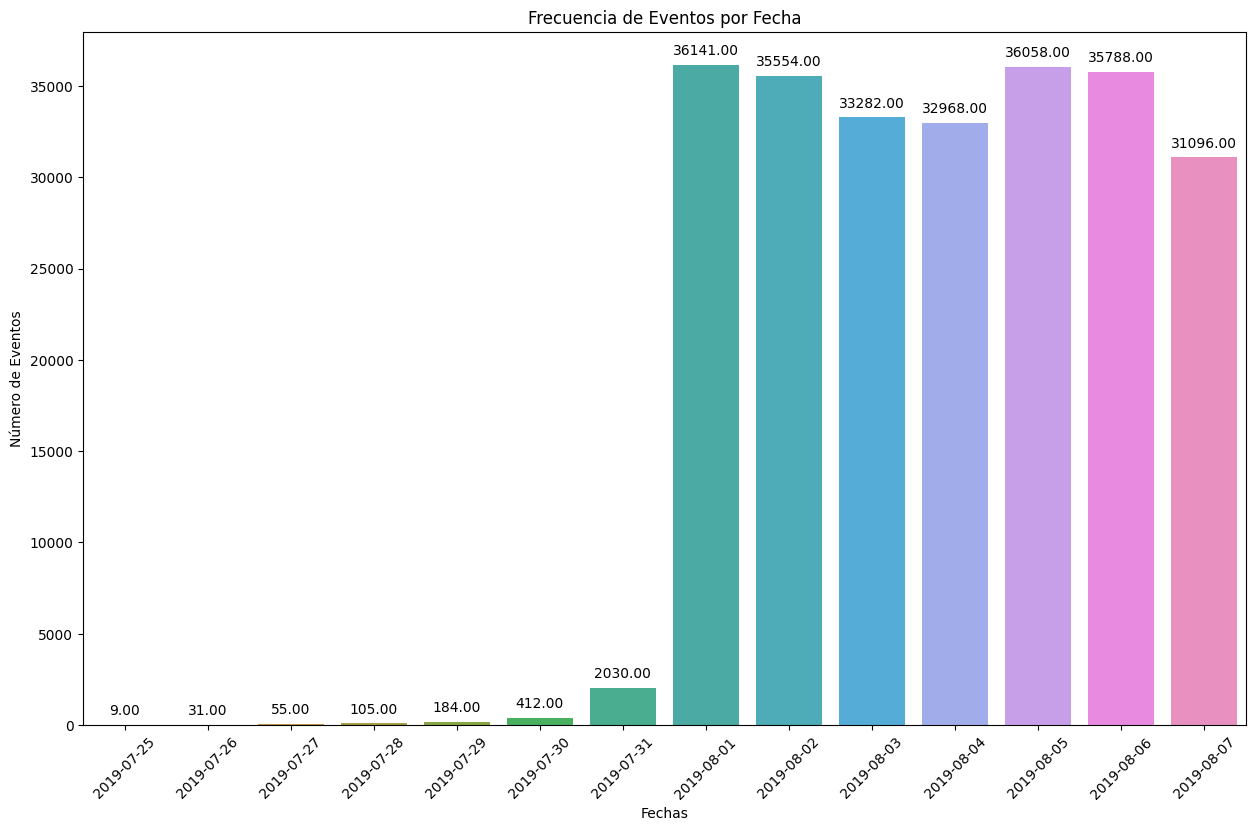

In [16]:
# Contar las fechas únicas y sus frecuencias
timePeriod = logs_exp_us['event_date'].value_counts().reset_index(name='count').sort_values(by='index')

# Graficar el histograma de frecuencias por fecha
plt.figure(figsize=(15, 9))
ax = sns.barplot(data=timePeriod, x='index', y='count')

# Añadir títulos y etiquetas
plt.title('Frecuencia de Eventos por Fecha')
plt.xlabel('Fechas')
plt.ylabel('Número de Eventos')
plt.xticks(rotation=45)

# Etiquetar las barras con los datos
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Mostrar la gráfica
plt.show()

La gráfica muestra una distribución de eventos a lo largo del periodo de tiempo cubierto por los datos. Hay un incremento notable de eventos a partir del 31 de julio de 2019, con picos en fechas específicas.

In [17]:
#Eliminar entradas de fechas anteriores al 1 de agosto de 2019
new_data = logs_exp_us[logs_exp_us['event_date'] >= pd.to_datetime('2019-08-01')]

# Calcular el número de usuarios y eventos antes de eliminar los datos antiguos
oldNumOfUsers = logs_exp_us['device_id'].nunique()
oldNumOfEvents = logs_exp_us['event_timestamp'].nunique()

#Calcular el número de usuarios y eventos después de eliminar los datos antiguos
newNumOfUsers = new_data['device_id'].nunique()
newNumOfEvents = new_data['event_timestamp'].nunique()

print('Hemos perdido ', (oldNumOfUsers - newNumOfUsers), ' usuarios y ', (oldNumOfEvents - newNumOfEvents), ' eventos al eliminar las entradas de datos anteriores a agosto de 2019.')

#Contar usuarios únicos en cada grupo experimental después de filtrar
expUsers = new_data.groupby('exp_id')['device_id'].nunique().reset_index()
expUsers.columns = ['exp_id', 'unique_users']
expUsers

Hemos perdido  17  usuarios y  2610  eventos al eliminar las entradas de datos anteriores a agosto de 2019.


,exp_id,unique_users
0,246,2484
1,247,2513
2,248,2537


La eliminación de entradas anteriores al 1 de agosto de 2019 resultó en una pérdida mínima de usuarios (17) y eventos (2610), lo cual es insignificante considerando el tamaño total de los datos.

Los grupos experimentales 246, 247 y 248 mantienen una distribución equilibrada de usuarios después del filtrado, lo cual es positivo para la validez de los resultados del experimento.

# Paso 4. Estudiar el embudo de eventos

**Qué eventos hay en los registros y su frecuencia de suceso**

In [18]:
#Utilizar value_counts() para encontrar la frecuencia de los eventos
eventsFreq = new_data['event_name'].value_counts().rename_axis('event_name').reset_index(name='count')
eventsFreq

,event_name,count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


El evento MainScreenAppear es el más frecuente, seguido por OffersScreenAppear, CartScreenAppear, y PaymentScreenSuccessful. El Tutorial es el menos frecuente.

**Encontrar la cantidad de usuarios que realizaron cada una de estas acciones y calcular la proporción de usuarios que realizaron la acción al menos una vez**

In [19]:
# Encontrar la cantidad de usuarios que realizaron cada acción
eventUsers = new_data.groupby('event_name')['device_id'].nunique().sort_values(ascending=False)
eventUsers = eventUsers.reset_index()
eventUsers.columns = ['event_name', 'unique_users']
eventUsers['user_percentage'] = (eventUsers['unique_users'] / new_data['device_id'].nunique()) * 100

# Calcular la proporción de usuarios que realizaron la acción al menos una vez
# Contar la cantidad de eventos por usuario para cada evento
at_least_once = new_data.groupby(['device_id', 'event_name'])['event_timestamp'].count().reset_index()

# Extraer solo los usuarios que tuvieron más de un evento por acción
at_least_once = at_least_once[at_least_once['event_timestamp'] > 1]

# Contar cuántos usuarios únicos tuvieron más de una acción por evento en comparación con todos los usuarios únicos
at_least_once = at_least_once.groupby('event_name')['device_id'].nunique() / new_data.groupby('event_name')['device_id'].nunique()
at_least_once = at_least_once.reset_index()
at_least_once.columns = ['event_name', 'at_least_once_percentage']
at_least_once['at_least_once_percentage'] = at_least_once['at_least_once_percentage'] * 100

# Fusionar las tablas
eventUsers = eventUsers.merge(at_least_once, on='event_name')

In [20]:
eventUsers

,event_name,unique_users,user_percentage,at_least_once_percentage
0,MainScreenAppear,7419,98.473586,96.684189
1,OffersScreenAppear,4593,60.963632,85.173089
2,CartScreenAppear,3734,49.561986,87.359400
3,PaymentScreenSuccessful,3539,46.973719,83.780729
4,Tutorial,840,11.149456,10.000000


* Alta Interacción con MainScreenAppear: La alta proporción de usuarios que ven la pantalla principal (98.47%) muestra una buena atracción inicial de los usuarios a la aplicación.

* Caída de Usuarios en las Siguientes Etapas: Solo el 60.96% de los usuarios pasan a la pantalla de ofertas, y menos de la mitad llegan hasta CartScreenAppear.

* Conversiones Relativamente Altas: Del 49.56% de los usuarios que llegan a CartScreenAppear, la mayoría completa la compra (46.97% en PaymentScreenSuccessful), mostrando una buena tasa de conversión una vez que los usuarios añaden artículos al carrito.

* Tutorial Menos Usado: El bajo porcentaje de uso del Tutorial podría indicar que la mayoría de los usuarios no necesitan guía, o puede sugerir que el tutorial no es fácilmente accesible o visible.

**¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia?**

De acuerdo a la frecuencia y naturaleza de los eventos registrados, podemos inferir el siguiente orden lógico para las acciones en la aplicación:

1. MainScreenAppear: Los usuarios comienzan por ver la pantalla principal.

2. OffersScreenAppear: Después de la pantalla principal, es probable que los usuarios naveguen a la pantalla de ofertas para ver promociones y productos.

3. CartScreenAppear: Luego, los usuarios que deciden comprar productos añadirán artículos al carrito y accederán a la pantalla del carrito.

4. PaymentScreenSuccessful: Finalmente, los usuarios completan la compra, lo que se refleja en la pantalla de pago exitoso.

5. Tutorial: Este evento es menos frecuente y puede ocurrir en diferentes etapas, quizás para nuevos usuarios que necesitan orientación en cualquier momento de su experiencia.

No todas estas acciones necesariamente forman una secuencia estricta que todos los usuarios sigan de manera uniforme. Sin embargo, podríamos ver una tendencia general:

    Pantalla Principal → Pantalla de Ofertas → Pantalla del Carrito → Pantalla de Pago Exitoso

El Tutorial parece ser una acción menos frecuente y no necesariamente parte de una secuencia fija, ya que puede aparecer en cualquier momento, especialmente para nuevos usuarios.

**Utilizar el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente**

In [21]:
# Crear un DataFrame para almacenar las proporciones del embudo de eventos
funnel = pd.DataFrame(columns=['event_name', 'unique_users', 'proportion'])

# Definir la secuencia de eventos
events_sequence = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Calcular el número de usuarios únicos en cada etapa
for i in range(len(events_sequence)):
    event = events_sequence[i]
    if i == 0:
        prev_users = new_data['device_id'].nunique()
    else:
        prev_event = events_sequence[i-1]
        prev_users = new_data[new_data['event_name'] == prev_event]['device_id'].nunique()
    
    current_users = new_data[new_data['event_name'] == event]['device_id'].nunique()
    proportion = current_users / prev_users if prev_users != 0 else 0
    
    funnel = funnel.append({'event_name': event, 'unique_users': current_users, 'proportion': proportion}, ignore_index=True)

# Mostrar el resultado del embudo de eventos
funnel['proportion'] = (funnel['proportion'] * 100).round(2)  # Convertir proporciones a porcentaje
funnel


,event_name,unique_users,proportion
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


Caída Inicial Significativa: La mayor pérdida de usuarios ocurre entre MainScreenAppear y OffersScreenAppear, con una proporción de retención de solo 61.91%.

Buena Retención Posterior: Una vez que los usuarios llegan a OffersScreenAppear, una alta proporción pasa a CartScreenAppear (81.30%) y finalmente a PaymentScreenSuccessful (94.78%).

**Utilizar el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente (incluyendo al evento Tutorial)**

In [22]:
# Crear un DataFrame para almacenar las proporciones del embudo de eventos
funnel = pd.DataFrame(columns=['event_name', 'unique_users', 'proportion'])

# Definir la secuencia de eventos incluyendo "Tutorial"
events_sequence = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

# Calcular el número de usuarios únicos en cada etapa
for i in range(len(events_sequence)):
    event = events_sequence[i]
    if i == 0:
        prev_users = new_data['device_id'].nunique()
    else:
        prev_event = events_sequence[i-1]
        prev_users = new_data[new_data['event_name'] == prev_event]['device_id'].nunique()
    
    current_users = new_data[new_data['event_name'] == event]['device_id'].nunique()
    proportion = current_users / prev_users if prev_users != 0 else 0
    
    funnel = funnel.append({'event_name': event, 'unique_users': current_users, 'proportion': proportion}, ignore_index=True)

# Mostrar el resultado del embudo de eventos
funnel['proportion'] = (funnel['proportion'] * 100).round(2)  # Convertir proporciones a porcentaje
funnel


,event_name,unique_users,proportion
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78
4,Tutorial,840,23.74


La baja proporción del evento Tutorial (23.74%) sugiere que el Tutorial no es parte del flujo principal de navegación de los usuarios y es utilizado solo por una pequeña fracción de los mismos.

**¿En qué etapa pierdes más usuarios y usuarias?
¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?**

In [23]:
# Identificar la etapa donde se pierden más usuarios
funnel['drop_off'] = funnel['unique_users'].diff().abs()

# Calcular el porcentaje de usuarios que completan todo el viaje desde el primer evento hasta el pago
total_users_start = funnel.loc[funnel['event_name'] == 'MainScreenAppear', 'unique_users'].values[0]
total_users_end = funnel.loc[funnel['event_name'] == 'PaymentScreenSuccessful', 'unique_users'].values[0]
completion_rate = (total_users_end / total_users_start) * 100

# Mostrar los resultados
print("Embudo de eventos:")
display(funnel)

print(f"El porcentaje de usuarios que hace todo el viaje desde el primer evento hasta el pago es: {completion_rate:.2f}%")

Embudo de eventos:


,event_name,unique_users,proportion,drop_off
0,MainScreenAppear,7419,98.47,NaN
1,OffersScreenAppear,4593,61.91,2826
2,CartScreenAppear,3734,81.30,859
3,PaymentScreenSuccessful,3539,94.78,195
4,Tutorial,840,23.74,2699


El porcentaje de usuarios que hace todo el viaje desde el primer evento hasta el pago es: 47.70%


* Mayor Pérdida de Usuarios: La etapa donde pierdes más usuarios es entre MainScreenAppear y OffersScreenAppear, con una pérdida de 2,826 usuarios.

* La segunda mayor pérdida ocurre en el Tutorial, con 2,699 usuarios menos, aunque esto no es parte del flujo principal de conversión.

* Alrededor del 47.70% de los usuarios que inician en MainScreenAppear completan el viaje hasta PaymentScreenSuccessful. Este porcentaje es significativo pero también indica que más de la mitad de los usuarios no completan el viaje.

* Las mayores caídas en las etapas iniciales (MainScreenAppear a OffersScreenAppear) sugieren áreas donde se pueden enfocar esfuerzos para mejorar la retención y la conversión.

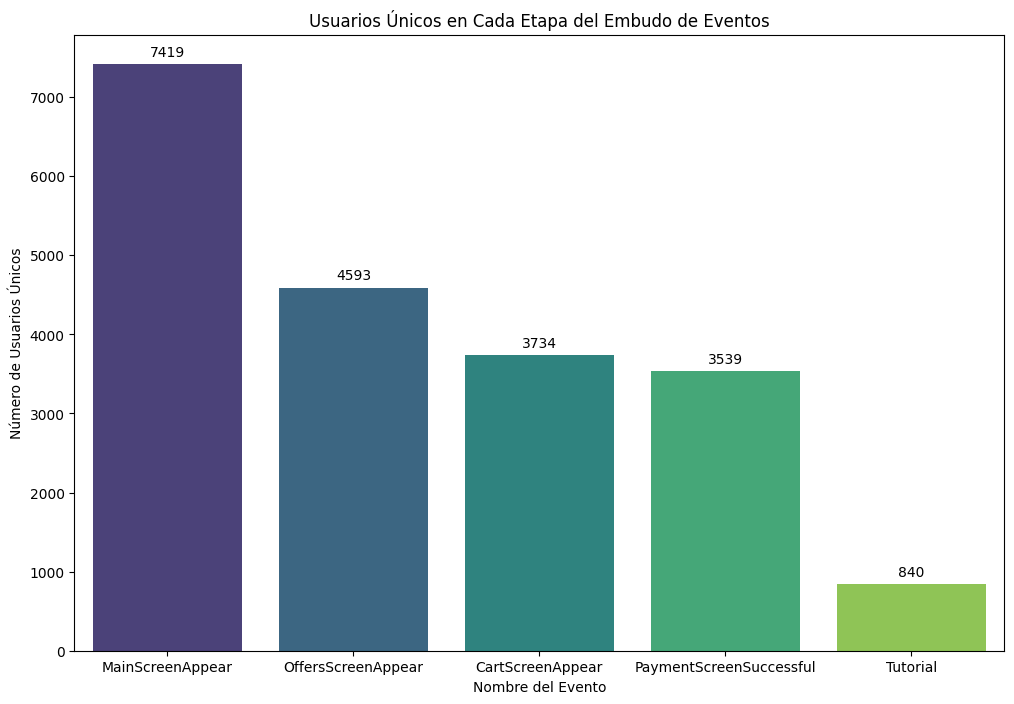

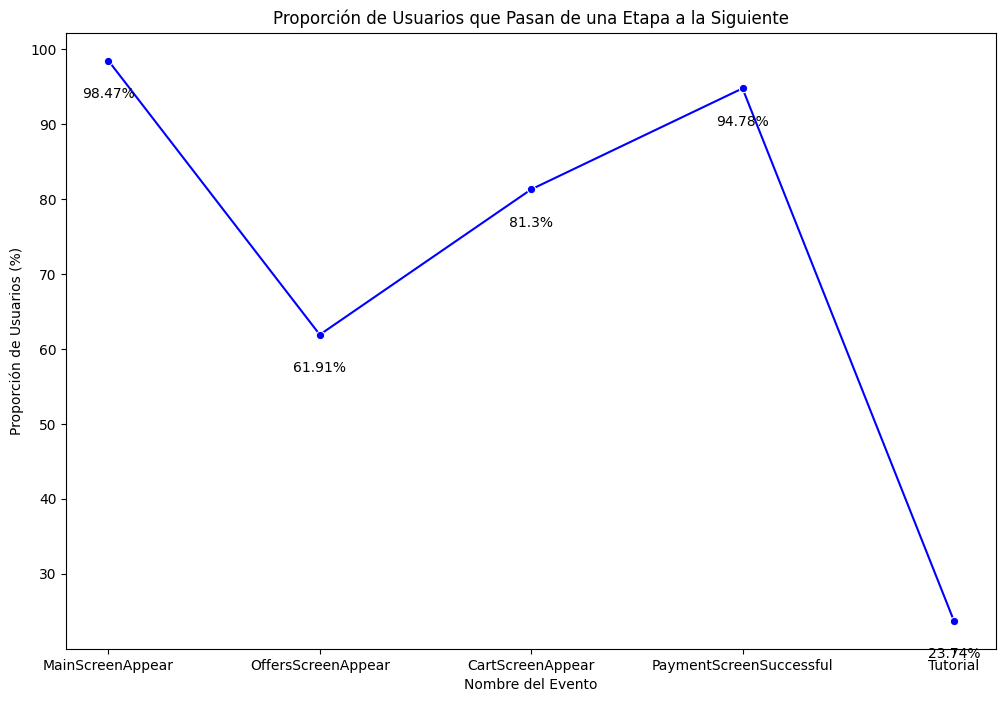

In [24]:
# Gráfico de barras para los usuarios únicos en cada etapa
plt.figure(figsize=(12, 8))
sns.barplot(x='event_name', y='unique_users', data=funnel, palette='viridis')

# Añadir títulos y etiquetas
plt.title('Usuarios Únicos en Cada Etapa del Embudo de Eventos')
plt.xlabel('Nombre del Evento')
plt.ylabel('Número de Usuarios Únicos')

# Etiquetar las barras con los datos
for index, row in funnel.iterrows():
    plt.text(index, row.unique_users + 100, round(row.unique_users, 2), color='black', ha="center")
plt.show()

# Gráfico de línea para las proporciones de usuarios que pasan de una etapa a la siguiente
plt.figure(figsize=(12, 8))
sns.lineplot(x='event_name', y='proportion', data=funnel, marker='o', color='b')

# Añadir títulos y etiquetas
plt.title('Proporción de Usuarios que Pasan de una Etapa a la Siguiente')
plt.xlabel('Nombre del Evento')
plt.ylabel('Proporción de Usuarios (%)')

# Etiquetar los puntos con los datos
for index, row in funnel.iterrows():
    plt.text(index, row.proportion - 5, f"{round(row.proportion, 2)}%", color='black', ha="center")
plt.show()

El gráfico de barras muestra claramente la cantidad de usuarios en cada etapa del embudo, permitiendo una visualización directa de la caída en cada etapa. El gráfico de línea ayuda a visualizar la proporción de usuarios que pasan de una etapa a la siguiente, destacando los puntos críticos donde ocurre la mayor pérdida.

# Paso 5. Estudiar los resultados del experimento

**¿Cuántos usuarios y usuarias hay en cada grupo?**

In [25]:
# Contar el número de usuarios únicos en cada grupo experimental
users_per_group = new_data.groupby('exp_id')['device_id'].nunique().reset_index()
users_per_group.columns = ['exp_id', 'unique_users']

# Mostrar los resultados
print(users_per_group)

   exp_id  unique_users
0     246          2484
1     247          2513
2     248          2537


Los tres grupos experimentales tienen un número similar de usuarios únicos, lo cual es favorable para un análisis comparativo válido. Adicionalmente, se puede decir que un tamaño de muestra similar en cada grupo contribuye a la validez de los resultados del experimento, minimizando posibles sesgos.

**Observar si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.**

In [26]:
# Crear una tabla dinámica con el número de usuarios únicos en cada grupo de control que pasa por cada acción
expGroups = new_data.pivot_table(index='event_name', values='device_id', columns='exp_id', aggfunc=lambda x: x.nunique()).reset_index()
expGroups.columns = ['event_name', '246', '247', '248']
expGroups = expGroups.sort_values(by='246', ascending=False)
expGroups

,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [27]:
from statsmodels.stats.proportion import proportions_ztest

# Crear un DataFrame para almacenar los resultados de las pruebas estadísticas
stat_results = pd.DataFrame(columns=['event_name', 'z_stat', 'p_value'])

# Comparar proporciones de usuarios entre los grupos 246 y 247 para cada evento
for index, row in expGroups.iterrows():
    count = np.array([row['246'], row['247']])
    nobs = np.array([expGroups['246'].sum(), expGroups['247'].sum()])
    stat, p_value = proportions_ztest(count, nobs)
    stat_results = stat_results.append({'event_name': row['event_name'], 'z_stat': stat, 'p_value': p_value}, ignore_index=True)

display(stat_results)

# Interpretar los resultados
for index, row in stat_results.iterrows():
    if row['p_value'] < 0.05:
        print(f"Hay una diferencia estadísticamente significativa en el evento {row['event_name']} entre los grupos 246 y 247.")
    else:
        print(f"No hay una diferencia estadísticamente significativa en el evento {row['event_name']} entre los grupos 246 y 247.")


,event_name,z_stat,p_value
0,MainScreenAppear,-0.867083,0.385897
1,OffersScreenAppear,0.166070,0.868102
2,CartScreenAppear,0.368086,0.712809
3,PaymentScreenSuccessful,0.709439,0.478052
4,Tutorial,-0.325722,0.744634


No hay una diferencia estadísticamente significativa en el evento MainScreenAppear entre los grupos 246 y 247.
No hay una diferencia estadísticamente significativa en el evento OffersScreenAppear entre los grupos 246 y 247.
No hay una diferencia estadísticamente significativa en el evento CartScreenAppear entre los grupos 246 y 247.
No hay una diferencia estadísticamente significativa en el evento PaymentScreenSuccessful entre los grupos 246 y 247.
No hay una diferencia estadísticamente significativa en el evento Tutorial entre los grupos 246 y 247.


No se encontraron diferencias estadísticamente significativas entre los grupos de control 246 y 247 para ninguno de los eventos analizados. La falta de diferencias significativas sugiere que los grupos de control 246 y 247 se dividieron correctamente y de manera equitativa.

**En cada uno de los grupos de control, encontrar el número de usuarios que realizaron el evento más popular y encontrar su participación.**

In [28]:
# Encontrar el evento más popular
most_popular_event = new_data['event_name'].value_counts().idxmax()
print(f"El evento más popular es: {most_popular_event}")

El evento más popular es: MainScreenAppear


In [29]:
from statsmodels.stats.proportion import proportions_ztest

# Función para realizar el análisis de cada evento
def analyze_event(event):
    event_data = new_data[new_data['event_name'] == event]
    users_246 = event_data[event_data['exp_id'] == 246]['device_id'].nunique()
    users_247 = event_data[event_data['exp_id'] == 247]['device_id'].nunique()
    total_246 = new_data[new_data['exp_id'] == 246]['device_id'].nunique()
    total_247 = new_data[new_data['exp_id'] == 247]['device_id'].nunique()
    
    proportion_246 = users_246 / total_246
    proportion_247 = users_247 / total_247
    
    count = np.array([users_246, users_247])
    nobs = np.array([total_246, total_247])
    stat, p_value = proportions_ztest(count, nobs)
    
    return {
        'event_name': event,
        'users_246': users_246,
        'proportion_246': proportion_246,
        'users_247': users_247,
        'proportion_247': proportion_247,
        'z_stat': stat,
        'p_value': p_value
    }

# Analizar el evento más popular
result = analyze_event(most_popular_event)
print(f"Análisis del evento más popular: {result}")

Análisis del evento más popular: {'event_name': 'MainScreenAppear', 'users_246': 2450, 'proportion_246': 0.9863123993558777, 'users_247': 2476, 'proportion_247': 0.9852765618782332, 'z_stat': 0.3093441851418436, 'p_value': 0.7570597232046099}


In [30]:
# Analizar todos los eventos
all_results = []

for event in new_data['event_name'].unique():
    result = analyze_event(event)
    all_results.append(result)

results_df = pd.DataFrame(all_results)

# Determinar la significancia estadística
results_df['significant'] = results_df['p_value'] < 0.05
display(results_df)

# Mostrar eventos con diferencias significativas
significant_events = results_df[results_df['significant']]
print("Eventos con diferencias estadísticamente significativas:")
display(significant_events)

,event_name,users_246,proportion_246,users_247,proportion_247,z_stat,p_value,significant
0,Tutorial,278,0.111916,283,0.112614,-0.078161,0.937700,False
1,MainScreenAppear,2450,0.986312,2476,0.985277,0.309344,0.757060,False
2,OffersScreenAppear,1542,0.620773,1520,0.604855,1.154988,0.248095,False
3,CartScreenAppear,1266,0.509662,1238,0.492638,1.203369,0.228834,False
4,PaymentScreenSuccessful,1200,0.483092,1158,0.460804,1.577995,0.114567,False


Eventos con diferencias estadísticamente significativas:


,event_name,users_246,proportion_246,users_247,proportion_247,z_stat,p_value,significant


No se encontraron diferencias estadísticamente significativas entre los grupos de control 246 y 247 para ninguno de los eventos analizados.

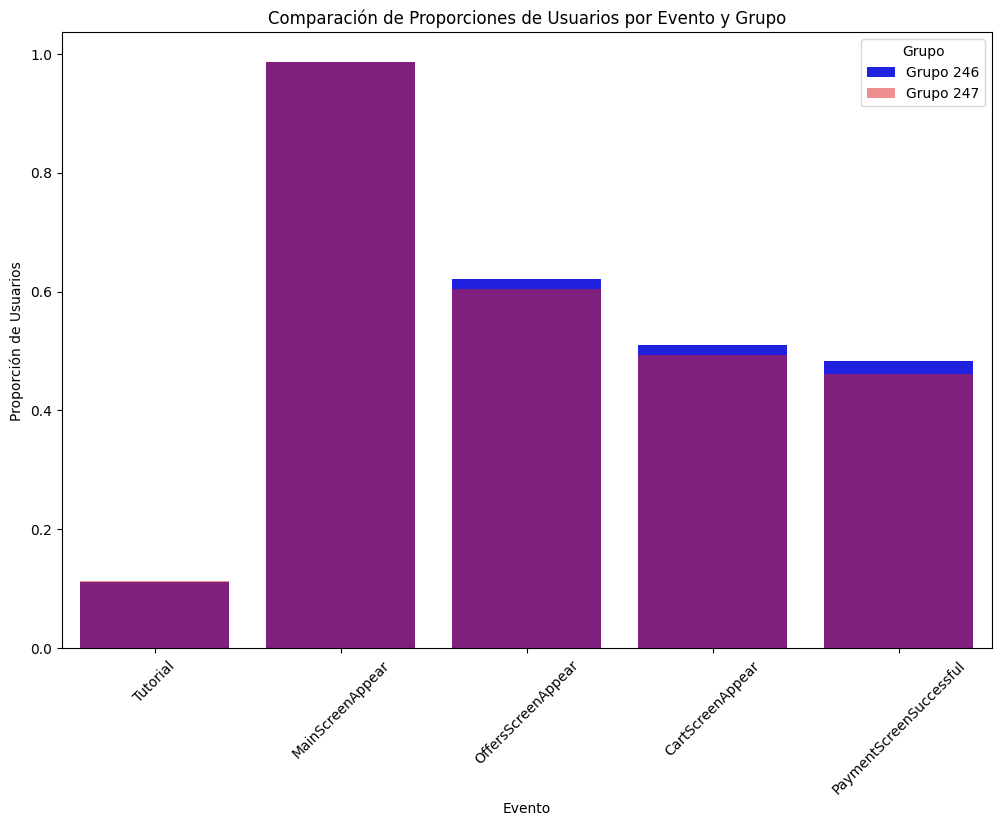

In [31]:
# Crear una visualización para comparar las proporciones de usuarios en cada evento
plt.figure(figsize=(12, 8))
sns.barplot(x='event_name', y='proportion_246', data=results_df, color='blue', label='Grupo 246')
sns.barplot(x='event_name', y='proportion_247', data=results_df, color='red', alpha=0.5, label='Grupo 247')

# Añadir títulos y etiquetas
plt.title('Comparación de Proporciones de Usuarios por Evento y Grupo')
plt.xlabel('Evento')
plt.ylabel('Proporción de Usuarios')
plt.legend(title='Grupo')

# Rotar etiquetas del eje X para mejor visualización
plt.xticks(rotation=45)
plt.show()


El gráfico muestra que las proporciones de usuarios que realizaron cada evento son muy similares entre los grupos 246 y 247, visualizando la ausencia de diferencias significativas.

Análisis:

* Evento más Popular: MainScreenAppear es el evento más popular, con la mayoría de los usuarios en ambos grupos de control realizándolo.

* Proporciones Similares: Las proporciones de usuarios que realizan cada evento son muy similares entre los grupos 246 y 247, sin diferencias significativas.

* Validación de Grupos de Control: La falta de diferencias significativas refuerza que los grupos de control se dividieron de manera equitativa y comparable.

**Comparar los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Comparar los resultados con los resultados combinados de los grupos de control**

In [32]:
# Encontrar el evento más popular en el grupo 248
most_popular_event_248 = new_data[new_data['exp_id'] == 248]['event_name'].value_counts().idxmax()
print(f"El evento más popular en el grupo 248 es: {most_popular_event_248}")

El evento más popular en el grupo 248 es: MainScreenAppear


In [33]:
# Analizar el evento más popular en el grupo 248
result_248 = analyze_event(most_popular_event_248)
print(f"Análisis del evento más popular en el grupo 248: {result_248}")

Análisis del evento más popular en el grupo 248: {'event_name': 'MainScreenAppear', 'users_246': 2450, 'proportion_246': 0.9863123993558777, 'users_247': 2476, 'proportion_247': 0.9852765618782332, 'z_stat': 0.3093441851418436, 'p_value': 0.7570597232046099}


In [34]:
# Función para analizar eventos en el grupo 248 y comparar con los grupos de control
def analyze_event_248(event):
    event_data = new_data[new_data['event_name'] == event]

    users_246 = event_data[event_data['exp_id'] == 246]['device_id'].nunique()
    users_247 = event_data[event_data['exp_id'] == 247]['device_id'].nunique()
    users_248 = event_data[event_data['exp_id'] == 248]['device_id'].nunique()

    total_246 = new_data[new_data['exp_id'] == 246]['device_id'].nunique()
    total_247 = new_data[new_data['exp_id'] == 247]['device_id'].nunique()
    total_248 = new_data[new_data['exp_id'] == 248]['device_id'].nunique()

    proportion_246 = users_246 / total_246
    proportion_247 = users_247 / total_247
    proportion_248 = users_248 / total_248

    count_control = np.array([users_246 + users_247, users_248])
    nobs_control = np.array([total_246 + total_247, total_248])
    stat_control, p_value_control = proportions_ztest(count_control, nobs_control)

    count_246 = np.array([users_246, users_248])
    nobs_246 = np.array([total_246, total_248])
    stat_246, p_value_246 = proportions_ztest(count_246, nobs_246)

    count_247 = np.array([users_247, users_248])
    nobs_247 = np.array([total_247, total_248])
    stat_247, p_value_247 = proportions_ztest(count_247, nobs_247)

    return {
        'event_name': event,
        'users_246': users_246,
        'proportion_246': proportion_246,
        'users_247': users_247,
        'proportion_247': proportion_247,
        'users_248': users_248,
        'proportion_248': proportion_248,
        'z_stat_control': stat_control,
        'p_value_control': p_value_control,
        'z_stat_246': stat_246,
        'p_value_246': p_value_246,
        'z_stat_247': stat_247,
        'p_value_247': p_value_247
    }

# Analizar todos los eventos
all_results_248 = []

for event in new_data['event_name'].unique():
    result = analyze_event_248(event)
    all_results_248.append(result)

results_df_248 = pd.DataFrame(all_results_248)

# Determinar la significancia estadística
results_df_248['significant_control'] = results_df_248['p_value_control'] < 0.05
results_df_248['significant_246'] = results_df_248['p_value_246'] < 0.05
results_df_248['significant_247'] = results_df_248['p_value_247'] < 0.05

display(results_df_248)

# Mostrar eventos con diferencias significativas con los controles combinados y separados
significant_events_control = results_df_248[results_df_248['significant_control']]
significant_events_246 = results_df_248[results_df_248['significant_246']]
significant_events_247 = results_df_248[results_df_248['significant_247']]

print("Eventos con diferencias estadísticamente significativas (Control combinado):")
display(significant_events_control)

print("Eventos con diferencias estadísticamente significativas (Grupo 246):")
display(significant_events_246)

print("Eventos con diferencias estadísticamente significativas (Grupo 247):")
display(significant_events_247)

,event_name,users_246,proportion_246,users_247,proportion_247,users_248,proportion_248,z_stat_control,p_value_control,z_stat_246,p_value_246,z_stat_247,p_value_247,significant_control,significant_246,significant_247
0,Tutorial,278,0.111916,283,0.112614,279,0.109972,0.299102,0.764862,0.219283,0.826429,0.298497,0.765324,False,False,False
1,MainScreenAppear,2450,0.986312,2476,0.985277,2493,0.982657,1.048854,0.294245,1.047276,0.294972,0.740980,0.458705,False,False,False
2,OffersScreenAppear,1542,0.620773,1520,0.604855,1531,0.603469,0.781930,0.434255,1.258082,0.208362,0.100709,0.919782,False,False,False
3,CartScreenAppear,1266,0.509662,1238,0.492638,1230,0.484825,1.335359,0.181759,1.759874,0.078429,0.555402,0.578620,False,False,False
4,PaymentScreenSuccessful,1200,0.483092,1158,0.460804,1181,0.465510,0.523783,0.600429,1.247388,0.212255,-0.335376,0.737342,False,False,False


Eventos con diferencias estadísticamente significativas (Control combinado):


,event_name,users_246,proportion_246,users_247,proportion_247,users_248,proportion_248,z_stat_control,p_value_control,z_stat_246,p_value_246,z_stat_247,p_value_247,significant_control,significant_246,significant_247


Eventos con diferencias estadísticamente significativas (Grupo 246):


,event_name,users_246,proportion_246,users_247,proportion_247,users_248,proportion_248,z_stat_control,p_value_control,z_stat_246,p_value_246,z_stat_247,p_value_247,significant_control,significant_246,significant_247


Eventos con diferencias estadísticamente significativas (Grupo 247):


,event_name,users_246,proportion_246,users_247,proportion_247,users_248,proportion_248,z_stat_control,p_value_control,z_stat_246,p_value_246,z_stat_247,p_value_247,significant_control,significant_246,significant_247


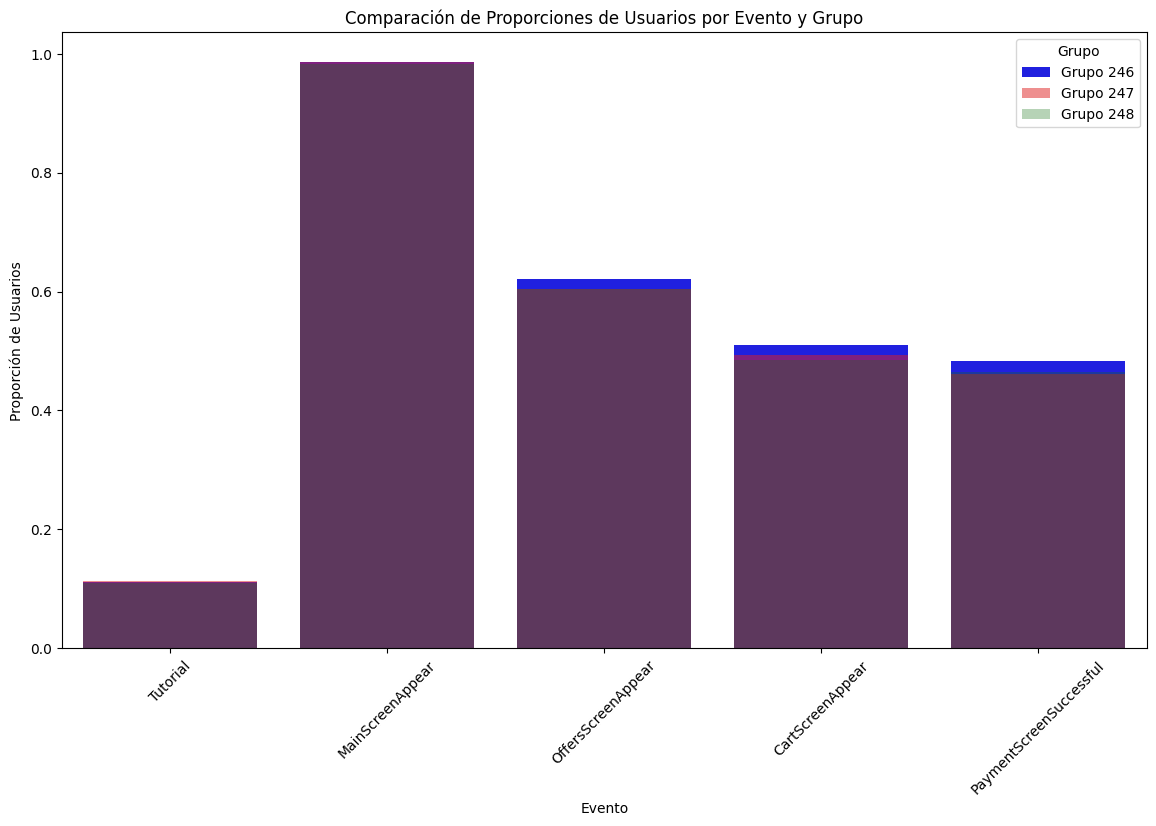

In [35]:
# Crear una visualización para comparar las proporciones de usuarios en cada evento
plt.figure(figsize=(14, 8))
sns.barplot(x='event_name', y='proportion_246', data=results_df_248, color='blue', label='Grupo 246')
sns.barplot(x='event_name', y='proportion_247', data=results_df_248, color='red', alpha=0.5, label='Grupo 247')
sns.barplot(x='event_name', y='proportion_248', data=results_df_248, color='green', alpha=0.3, label='Grupo 248')

# Añadir títulos y etiquetas
plt.title('Comparación de Proporciones de Usuarios por Evento y Grupo')
plt.xlabel('Evento')
plt.ylabel('Proporción de Usuarios')
plt.legend(title='Grupo')

# Rotar etiquetas del eje X para mejor visualización
plt.xticks(rotation=45)
plt.show()


* No hay diferencia estadísticamente significativa en la proporción de usuarios que realizaron MainScreenAppear entre el grupo 248 y los grupos de control (246 y 247).

* Para todos los eventos no se encontraron diferencias estadísticamente significativas entre el grupo 248 y los grupos de control, ya sea individualmente (246 vs 248, 247 vs 248) o combinados (246+247 vs 248).

* El gráfico muestra que las proporciones de usuarios que realizaron cada evento son muy similares entre los grupos 246, 247 y 248, visualizando la ausencia de diferencias significativas.

* MainScreenAppear es el evento más popular en el grupo 248, al igual que en los grupos de control.

* Las proporciones de usuarios que realizan cada evento son muy similares entre los grupos 246, 247 y 248, sin diferencias significativas.

* La falta de diferencias significativas sugiere que el cambio experimental en el grupo 248 no tuvo un impacto significativo en el comportamiento de los usuarios en comparación con los grupos de control.

**¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente?**

**Nivel de Significación Establecido**

Hasta ahora, hemos utilizado un nivel de significación (alpha) de 0.05 para probar las hipótesis estadísticas. Esto es estándar en muchos análisis estadísticos, indicando un 5% de probabilidad de rechazar una hipótesis nula verdadera (falso positivo).

Vamos a calcular cuántas pruebas de hipótesis hemos realizado. Cada evento comparado entre los grupos (246 vs 248, 247 vs 248, controles combinados vs 248) cuenta como una prueba.

**Número de eventos analizados:** 5 eventos (Tutorial, MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful).

**Comparaciones:** Para cada evento, realizamos 3 comparaciones:

Control combinado vs 248

Grupo 246 vs 248

Grupo 247 vs 248

**Número Total de Pruebas**

Total de pruebas de hipótesis realizadas = número de eventos × número de comparaciones = 5 eventos × 3 comparaciones = 15 pruebas.

**Nivel de Significación y Falsos Positivos**

Con un nivel de significación de 0.1, uno de cada 10 resultados podría ser falso. Si realizamos 15 pruebas, podemos esperar aproximadamente:

    0.1 × 15 pruebas = 1.5 resultados falsos positivos.

**Ajuste del Nivel de Significación**

Dado el contexto del experimento y la cantidad de pruebas realizadas, podrías considerar ajustar el nivel de significación usando una corrección de Bonferroni para controlar el error de Tipo I. El nuevo nivel de significación sería:

alpha ajustado= alpha original (0.05) / número de pruebas(15) = 0.0033

In [36]:
# Determinar la significancia estadística con el nuevo nivel de significación
results_df_248['significant_control'] = results_df_248['p_value_control'] < 0.0033
results_df_248['significant_246'] = results_df_248['p_value_246'] < 0.0033
results_df_248['significant_247'] = results_df_248['p_value_247'] < 0.0033

display(results_df_248)

# Mostrar eventos con diferencias significativas con los controles combinados y separados con el nuevo nivel de significación
significant_events_control = results_df_248[results_df_248['significant_control']]
significant_events_246 = results_df_248[results_df_248['significant_246']]
significant_events_247 = results_df_248[results_df_248['significant_247']]

print("Eventos con diferencias estadísticamente significativas (Control combinado) con alpha ajustado:")
display(significant_events_control)

print("Eventos con diferencias estadísticamente significativas (Grupo 246) con alpha ajustado:")
display(significant_events_246)

print("Eventos con diferencias estadísticamente significativas (Grupo 247) con alpha ajustado:")
display(significant_events_247)


,event_name,users_246,proportion_246,users_247,proportion_247,users_248,proportion_248,z_stat_control,p_value_control,z_stat_246,p_value_246,z_stat_247,p_value_247,significant_control,significant_246,significant_247
0,Tutorial,278,0.111916,283,0.112614,279,0.109972,0.299102,0.764862,0.219283,0.826429,0.298497,0.765324,False,False,False
1,MainScreenAppear,2450,0.986312,2476,0.985277,2493,0.982657,1.048854,0.294245,1.047276,0.294972,0.740980,0.458705,False,False,False
2,OffersScreenAppear,1542,0.620773,1520,0.604855,1531,0.603469,0.781930,0.434255,1.258082,0.208362,0.100709,0.919782,False,False,False
3,CartScreenAppear,1266,0.509662,1238,0.492638,1230,0.484825,1.335359,0.181759,1.759874,0.078429,0.555402,0.578620,False,False,False
4,PaymentScreenSuccessful,1200,0.483092,1158,0.460804,1181,0.465510,0.523783,0.600429,1.247388,0.212255,-0.335376,0.737342,False,False,False


Eventos con diferencias estadísticamente significativas (Control combinado) con alpha ajustado:


,event_name,users_246,proportion_246,users_247,proportion_247,users_248,proportion_248,z_stat_control,p_value_control,z_stat_246,p_value_246,z_stat_247,p_value_247,significant_control,significant_246,significant_247


Eventos con diferencias estadísticamente significativas (Grupo 246) con alpha ajustado:


,event_name,users_246,proportion_246,users_247,proportion_247,users_248,proportion_248,z_stat_control,p_value_control,z_stat_246,p_value_246,z_stat_247,p_value_247,significant_control,significant_246,significant_247


Eventos con diferencias estadísticamente significativas (Grupo 247) con alpha ajustado:


,event_name,users_246,proportion_246,users_247,proportion_247,users_248,proportion_248,z_stat_control,p_value_control,z_stat_246,p_value_246,z_stat_247,p_value_247,significant_control,significant_246,significant_247


Conclusión:

ncluso con el nivel de significación ajustado, no se encontraron diferencias estadísticamente significativas entre los grupos experimentales y de control.

    Control de Error Tipo I: El ajuste usando la corrección de Bonferroni reduce la probabilidad de obtener resultados falsos positivos, confirmando que las conclusiones iniciales sobre la falta de diferencias significativas se mantienen válidas.